<a href="https://colab.research.google.com/github/ltoosaint24/DS-Unit-2-Kaggle-Challenge/blob/master/Loveline_toussaint_LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [ ]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [ ]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [ ]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


In [ ]:
train['extraction_type_class'].value_counts()

gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: extraction_type_class, dtype: int64

In [ ]:
train['extraction log'] = train['extraction_type_class'].apply(lambda x: 0 if x == 'submersible' else 1)
train['extraction log']

0        1
1        1
2        1
3        0
4        1
        ..
59395    1
59396    1
59397    1
59398    1
59399    1
Name: extraction log, Length: 59400, dtype: int64

In [ ]:
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,extraction log
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional,1
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,1
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional,1
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional,0
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional,1


In [ ]:
def wrangle(X):
  X = X.copy()

  high_card_cols = [col for col in X.select_dtypes('object').columns
                    if X[col].nunique() > 100]
  X.drop(columns = high_card_cols, inplace = True)

  cols = ['extraction_type_group', 'quantity']
  X.drop(columns = cols, inplace = True)

  if 'extraction_type_class' in X.columns:
    X['extraction log'] = X['extraction_type_class'].apply(lambda x: 0 if x == 'submersible' else 1)

    X.drop(columns = 'extraction_type_class', inplace =False)

  return X

In [ ]:
train = wrangle(train)


In [ ]:
test = wrangle(test)

In [ ]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

target = 'extraction log'
y = train[target]
x = train.drop(columns = target )

X_train, X_val, y_train, y_val = train_test_split(x,y,test_size =0.2, random_state =42)

assert len(X_train) + len(X_val) == len(x)

In [ ]:
y_train.value_counts(normalize = True)



1    0.895581
0    0.104419
Name: extraction log, dtype: float64

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize = True).max())

Baseline Accuracy: 0.8955808080808081


In [ ]:
model = make_pipeline(OrdinalEncoder(),
                      SimpleImputer(),
                      RandomForestClassifier(n_estimators = 50,
                                             n_jobs = -1,
                                             random_state = 42))
model.fit(X_train, y_train);

In [ ]:
#Check Metrics

In [ ]:
print('Training Accuracy', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy 1.0
Validation Accuracy: 1.0


In [ ]:
#Confusion Matrix

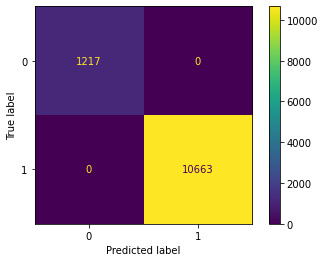

In [ ]:
plot_confusion_matrix(model,
                      X_val,
                      y_val,
                      values_format ='.0f'
                      );

In [ ]:
print('Recall:', 10663/(0 + 10663) ) #This explains that 100% of the predicted to be submersible

Recall: 1.0


In [ ]:
print(classification_report(y_val, model.predict(X_val),
                            target_names = ['extraction_class', 'extraction']))

                  precision    recall  f1-score   support

extraction_class       1.00      1.00      1.00      1217
      extraction       1.00      1.00      1.00     10663

        accuracy                           1.00     11880
       macro avg       1.00      1.00      1.00     11880
    weighted avg       1.00      1.00      1.00     11880



In [22]:
#Case Study
n_inspections = 2000

y_val.value_counts(normalize = True).min()

0.10244107744107744

In [23]:
data = {'y_val': y_val,
        'y_pred': model.predict(X_val)}

results = pd.DataFrame(data)
mask = results['y_pred'] == 1
sample = results[mask].sample(n_inspections)
print('Inspections conducted:', n_inspections)
print('Pumps repaired', sample['y_val'].sum())
print('Funds wasted:', (n_inspections - sample.y_val.sum())* 100)

Inspections conducted: 2000
Pumps repaired 2000
Funds wasted: 0


In [26]:
data = {'y_val': y_val,
        'y_pred_proba': model.predict_proba(X_val)[:, -1]}
results = pd.DataFrame(data)
threshold = 0.9

mask = results['y_pred_proba']> threshold

sample = results[mask].sample(n_inspections)

print('Inspections conducted:', n_inspections)
print('Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', (n_inspections -sample.y_val.sum()) * 100)

Inspections conducted: 2000
Pumps repaired: 2000
Funds wasted: 0
